Objective: Determine Weyl chamber regions spanned by x iterations of $\sqrt[n]{iSwap}$ circuit templates.\
a. Step through weyl coordinates -> Pass to NuOp -> Color point based on length of template required\
b. (Later) Vectorization ML Task

In [3]:
import numpy as np
import weylchamber  
from circuit_template import TemplateCircuit
from scipy import optimize as opt
import pickle
import weylchamber
from custom_gates import *
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

SUCCESS_THRESHOLD = 1e-9

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)
# use ERROR if you want to hide verbose print outs
#logger.setLevel(logging.ERROR)

In [3]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        weyl_coordinates=(0,0,0),
        objective_function_name="square",
        template_iter_range=range(2, 4)
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "nuop|basic" or "weyl"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.weyl_coordinates = weyl_coordinates
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range

    def run(self):
        # run minimize on the remaining samples
        best_result, best_Xk, best_cycles = None, None, None

        obj = self._objective_function(self.obj_f_name)
        best_result, best_Xk, best_cycles = self.minimize(
            obj=obj, t_range=self.template_iter_range)
                
        return best_result, best_Xk, best_cycles

    def minimize(self, obj, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        # def callbackF(xk):
        #     loss = obj(xk)
        #     temp_training_loss.append(loss)

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Starting cycle length {t}")

            self.template.build(n_repetitions=t)

            starting_attempts = 5
            for _ in range(starting_attempts):
                result = opt.minimize(
                    fun=obj,
                    x0=self.template.initial_guess(),
                    options={"maxiter": 200},
                )

                # result is good, update temp vars
                if best_result is None or result.fun < best_result:
                    best_result = result.fun
                    best_Xk = result.x
                    best_cycles = self.template.cycles

                # already good enough, save time by stopping here
                if best_result < 1e-9:
                    logging.info(f"Break on cycle {t}")
                    break

            if best_result < 1e-9:
                break

        logging.info(f"loss= {best_result}")
        return best_result, best_Xk, best_cycles

    def _objective_function(self, name):
        if name == "square":
            target = weylchamber.canonical_gate(*self.weyl_coordinates).full()
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))
        else:
            raise ValueError(f"No objective function named {name}")

In [4]:
def _pickle_load(filename):
    #try to open file if it exists
    try:
        with open(filename, 'rb') as f:
            loaded_data = pickle.load(f)
    except FileNotFoundError:
        loaded_data = {}
    #    with open(filename, 'a') as f:
    #        #do nothing, just want to create file
    #        pass
    return loaded_data

In [5]:
def collect_data(N=1, base_gate_class= RiSwapGate, gate_params=[1/2], template_range=[2], filename=None, overwrite_saved=False):
    """This method generates a Weyl Chamber point, converts it to a gate, then asks NuOp how many template cycles it needs to make that gate"""

    circuit = TemplateCircuit(base_gate_class=[base_gate_class], gate_2q_params=gate_params)
    dict_data = {} #(coordinate : (result, Xk, cycles))

    if filename is None:
        raise ValueError("missing filename")
        
    dict_data = _pickle_load(filename) if not overwrite_saved else {}

    #we don't want this to be random, this is used for filling in the weyl chamber regions missed in other data collection method
    #weyl_coordinate_list = [weylchamber.random_weyl_point() for _ in range(N-len(dict_data.keys()))]
    #define edge O->P->A3
    point_O = (0,0,0)
    point_A1 = (1, 0, 0)
    point_A2 = (1/2, 1/2,0)
    point_A3 = (1/2,1/2,1/2)
    exterior_edges = [(point_O, point_A1), (point_O, point_A2), (point_O, point_A3), (point_A1, point_A2), (point_A1, point_A2), (point_A2, point_A3)]
    
    weyl_coordinate_list = []
    for edge_A, edge_B in exterior_edges:
        temp_coord = [(x,y,z) for x,y,z in zip(*[np.linspace(edge_A[i], edge_B[i], num=N) for i in range(len(point_O))])]
        weyl_coordinate_list.extend(temp_coord)
        
    for coord_index, coordinate in enumerate(weyl_coordinate_list):
        #check if coordinate already exists in loaded_data
        if coordinate in dict_data.keys():
            logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Found saved coordinate: {coordinate}")
            continue

        logging.info(f"({1+coord_index}/{len(weyl_coordinate_list)}) Training coordinate: {coordinate}")
        optimizer = TemplateOptimizer(circuit, weyl_coordinates=coordinate, objective_function_name="square", template_iter_range=template_range)
        best_result, best_Xk, best_cycles = optimizer.run()

        if best_result > SUCCESS_THRESHOLD:
            #raise ValueError("Failed to converge, try adjusting max_template_size")
            #rather than raise failed to converge error, just save its actual reached coordinate
            dict_data[coordinate] = None #mark old coordinate as unreachable
            coordinate = weylchamber.c1c2c3(circuit.eval(best_Xk))
            logging.info(f"Given coordinate failed, instead found closest point was {coordinate}")
            best_result = 0 #by definition, since we are declaring coordinate equal to the state of the template circuit

        #write into temp data dict
        dict_data[coordinate] = (best_result, best_Xk, best_cycles)

    
    #at end, save back data dict
    logging.info("Saving data back to file")
    with open(filename, 'wb+') as f:
        pickle.dump(dict_data, f)

    return dict_data

def collect_data2(N=100, gate_params=[1/2], template_range=[2,3]):
    """In contrast, this generates a template of a set size, then randomly sets parameters to see where it ends up in the Weyl Chamber"""
    temp_data = {}
    for template_size in template_range:
        circuit = TemplateCircuit(gate_2q_params=gate_params)
        circuit.build(template_size)

        for _ in range(N):
            Xk = circuit.initial_guess()
            random_U = circuit.eval(Xk)
            coordinate = weylchamber.c1c2c3(random_U)
            temp_data[coordinate] = template_size
    return temp_data

In [6]:
def collect_data3(N=1, base_gate_class= RiSwapGate, gate_params=[1/2], template_range=[2], filename=None, overwrite_saved=False):
    """Reference: https://arxiv.org/pdf/2009.13853.pdf
    This will be a combination of data collection from methods 1 and 2.
    Recall that method 1 is "shrinkwrap", walk the exterior edges and either succeeds and add it to set, or instead add the closest point we got instead, in hopes that the backup closest points will be lying along the boundary
    Recall that method 2 is just twittling the 1Q gate parameters so we splotter the region but will tend to be in the middle and will fail to capture the edges
    Method 3 is hopes to combine these methods, reduce the total number of samples, and more accurately bind the polyhedra.

    Assumptions
    1- weyl chamber will be symmetrical across c1=pi/2
    2- spanning regions may be disjointed but are always convex

    Active learning algorithm:
    begin active learning with first the random splotter of data which are generated for free by letting the 1Q parameters twirl. 
    second, sample the exterior vertices I,A1-3 as a way to either (a) be done if all returns 1, or 
    (b) need some 0s in dataset to begin next step. third, we need to decide which points we want to check next. 
    everytime we sample a point outside of the boundary we get back the closest point it was able to reach instead 
    (but be careful, the closest point is defined by unitary distance instead of weyl distance -
     you might get 'boundary wrap-arounds' for example.

    how do you select which data points you would like to query next? one example, 
    "continually queries for the label of the vertex that bisets the shortest path between any pair of oppositely-labeled vertices". 
    why this is great- in shrinkwrap algorithm, when a coordinate fails, it gets thrown away and it just keeps in the '1' label set the nearest coordinate. 
    this algorithm keeps both coordinates in two separate labels - (both inflating from the middle and shrinking from the outside!)

    next step, how many times do you need to repeat active learning phase until decide when to be done? simplest method - pick a set number of samples. 
    better method - we find boundary when difference between bisecting point is sufficiently close? 
    better methods need more investigation

    something to quickly verify-
    if we have a template circuit, can we just ignore the outer most 1Q parameters. 
    treat the rest of the template as single 2Q gate and it should always go to the same coordinates not dependent on the outer ones. 
    This reduces the parameter search by a constant of 12.
    However, because our metric of success does not work with only weyl chamber coordinates I think this would fail
    What if we switched over to Makhil coordinates as supposedely these are differentiable?
    Need to see if the benefit of reducing the total number of parameters is worth it
    """

    #TODO: verfiy scope of variables
    def atomic_collect(target_coordinates, template):
        #check if coordinate already exists in loaded_data
        if target_coordinates in dict_data.keys():
            logging.info(f"Found saved: {target_coordinates}")
            return

        logging.info(f"SEARCHING: {target_coordinates}")
        optimizer = TemplateOptimizer(template, weyl_coordinates=target_coordinates, objective_function_name="square", template_iter_range=template_range)
        best_result, best_Xk, best_cycles = optimizer.run()

        if best_result <= SUCCESS_THRESHOLD:
            # label target coordinate as success
            label = 1
            logging.info(f"Success: {target_coordinates}")
        else:
            # label target coordinate as fail, label alternative coordinate as succss
            label = 0
            alternative_coordinate = weylchamber.c1c2c3(circuit.eval(best_Xk))
            logging.info(f"Fail: {target_coordinates}, Alternative: {alternative_coordinate}")
            dict_data[alternative_coordinate] = (1, 0) #, best_Xk, best_cycles)
    
        #write back into temp data dicts
        # best_XK, best_cycles may be redundant, can elimate saving this for speedup
        # we should retain best_Xk data later for preseeding, but ignore for now
        dict_data[target_coordinates] = (label, best_result) #, best_Xk, best_cycles)
        return 

    #TODO: modified circuit template that elimates the exterior 1Q gates
    circuit = TemplateCircuit(base_gate_class=[base_gate_class], gate_2q_params=gate_params)

    dict_data = {} #[coordinate : (label, fidelity result, Xk, cycles)]

    if filename is None:
        raise ValueError("value error")
    dict_data = _pickle_load(filename) if not overwrite_saved else {}
    
    #step 1, get the random scatter data
    scatter_data = collect_data2(N=100, gate_params=gate_params, template_range=template_range)
    
    #TODO: add scatter data to dict_data with label '1'

    #step 2, get baseline exterior edges, try I, A1-3
    

    #TODO: if I, A1-3 succeed then done, achieve full span



In [7]:
%matplotlib widget
#this command lets the weyl chamber be rotated in 3d

In [8]:
c = ["black", "black", "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:cyan", "tab:pink", "tab:brown"]

def weyl_region_plot(base_gate=RiSwapGate, gate_params=[1/2], template_range=[2], filename=None) -> list:
    w= weylchamber.WeylChamber()

    #Step 1. Add the Template -> Weyl chamber points
    #We expect these to be clustered in the center
    # loaded_data = collect_data2(N=100, gate_params=gate_params, template_range=template_range)
    # for coordinate, result in loaded_data.items():
    #     color = c[result%len(c)]
    #     w.scatter(*coordinate, color=color)

    #Step 2. Add the Weyl Chamber points -> Template length data
    #This is useful for forcing coordinates that aren't reached by the random distribution

    N=11
    #set template_size=2, so if it fails, we instead get back its closest guess in order to create internal weyl edges
    if filename is None:
        filename = f"data_11/weyl_spanning_1-{str(int(1/gate_params[0]))}-{template_range}.pkl"
    loaded_data = collect_data(N=N, base_gate_class=base_gate, gate_params=gate_params, template_range=template_range, filename=filename)
    # loaded_data = _pickle_load(filename)
    
    for coordinate, result in loaded_data.items():
        # check that optimizer successfully converged
        if result is not None and result[0] < 1e-9:

            # color that coordinate with best_cycles->color
            color = c[result[2]%len(c)]
            w.scatter(*coordinate, color=color)

    fig = plt.figure()
    fig.suptitle(f"Weyl Chamber span {base_gate.latex_string(gate_params)} with {template_range[0]} steps")
    w.plot(fig)

    #for convex hull avoid coplanar precision errors by a small degree of rounding 
    coords = np.array([k for k,v in loaded_data.items() if v is not None and v[0] < 1e-9])
    #return np.round(coords, 5)
    return coords

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.5        0.25000001 0.24999999]


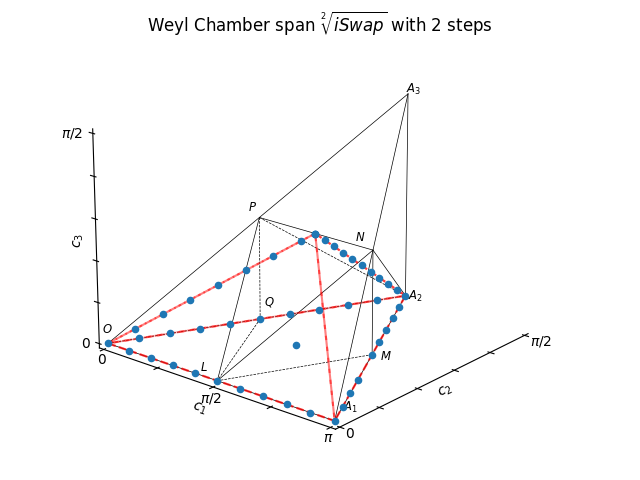

In [80]:
coordinates = weyl_region_plot(gate_params=[1/2], template_range=[2])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', alpha=0.5)

#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
# plt.scatter(*[[mi] for mi in m], color='black', s=100)
plt.show()

BREAK

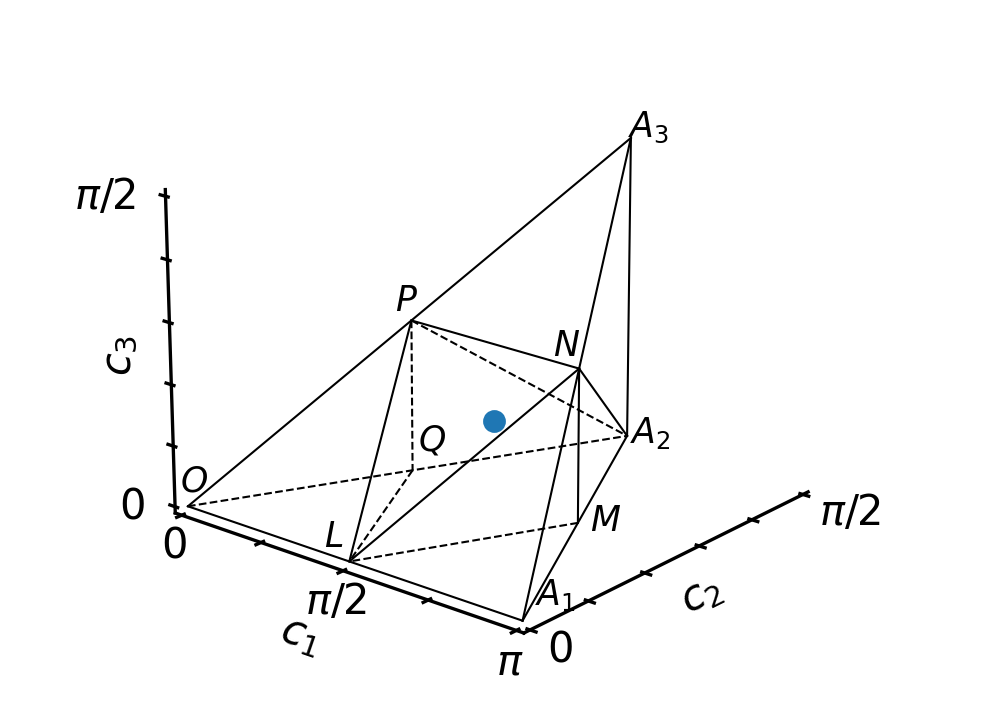

In [20]:
strange_gate = lambda _ : CanonicalGate(np.pi/4,np.pi/8, np.pi/16)
#pick point right in the middle of the chamber
# p = strange_gate(_).__array__()
# w = weylchamber.WeylChamber()
# w.add_point(*weylchamber.c1c2c3(p))
# w.plot()

In [ ]:
coordinates = weyl_region_plot(base_gate=strange_gate, gate_params=[None], template_range=[2], filename="data/weyl_spanning_strange_2.pkl")
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.5 0.5 0.5]


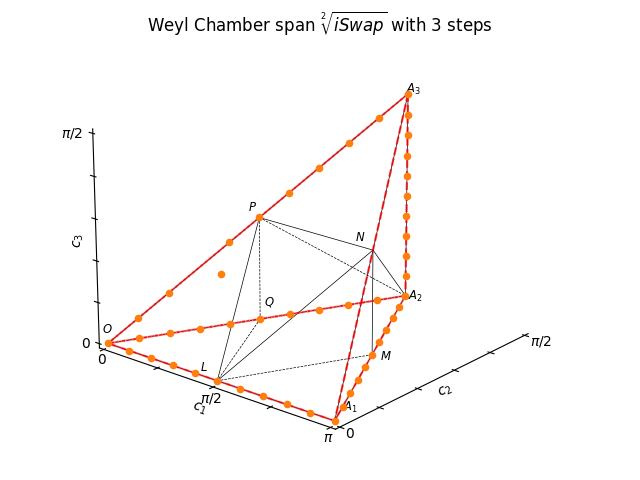

In [58]:
coordinates = weyl_region_plot(gate_params=[1/2], template_range=[3])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', alpha=0.5)

#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
# plt.scatter(*[[mi] for mi in m], color='black', s=100)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.66666667 0.16666687 0.16666647]


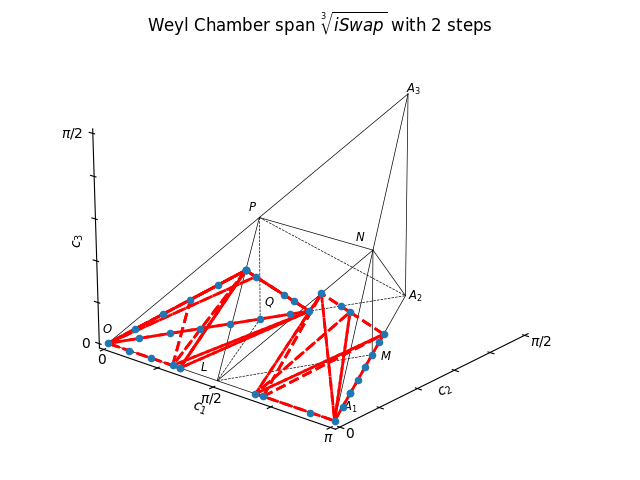

In [59]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.66666551 0.33333324 0.33333227]


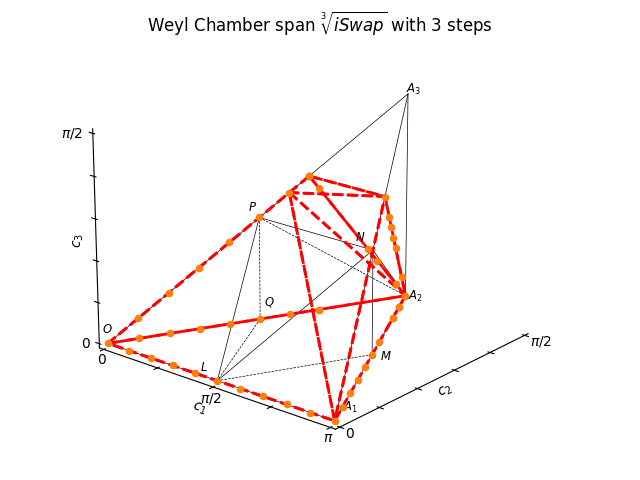

In [60]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[3])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.44444764 0.44444434 0.4444412 ]


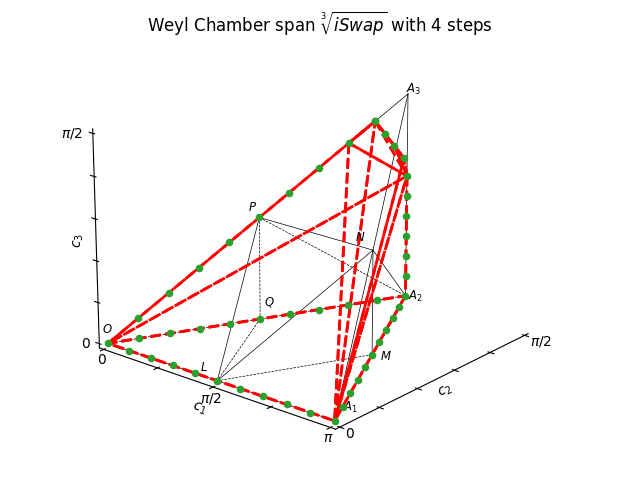

In [61]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[4])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.5 0.5 0.5]


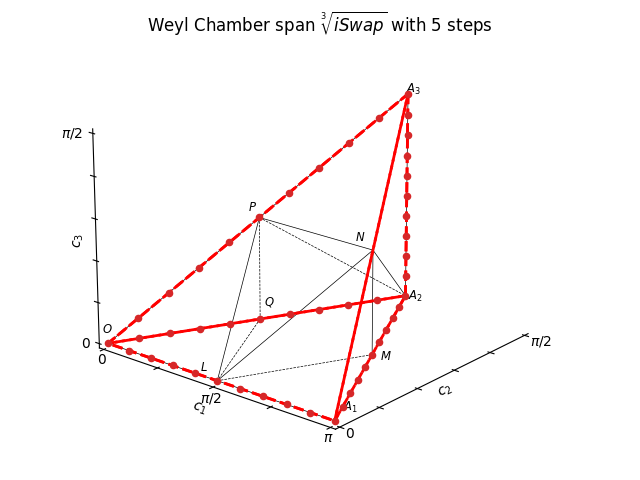

In [62]:
coordinates = weyl_region_plot(gate_params=[1/3], template_range=[5])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.25       0.12500006 0.12499994]


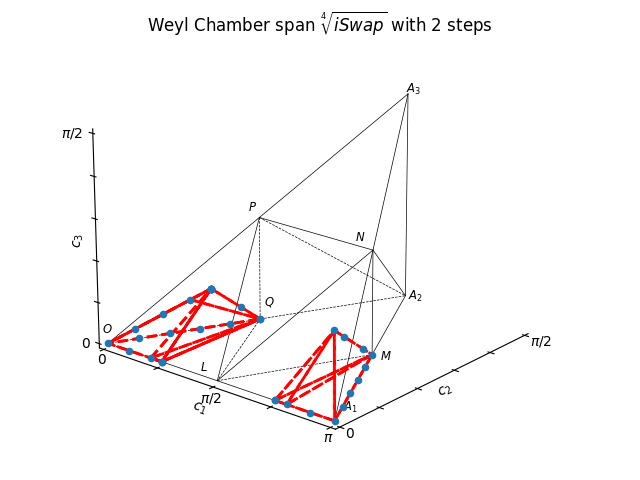

In [63]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.25000316 0.25       0.24999684]


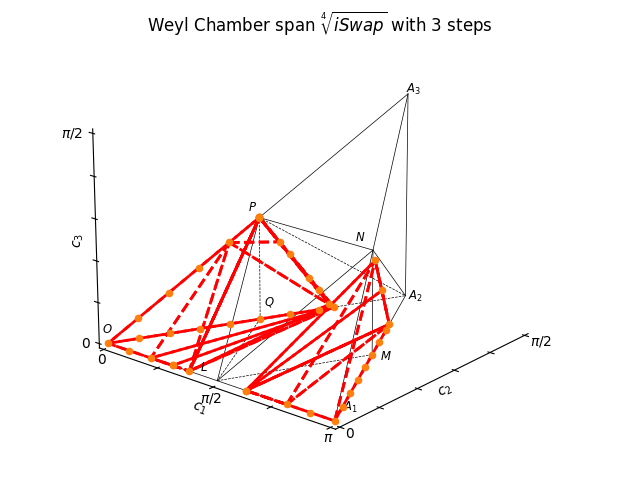

In [64]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.33334448 0.33333067 0.33332475]


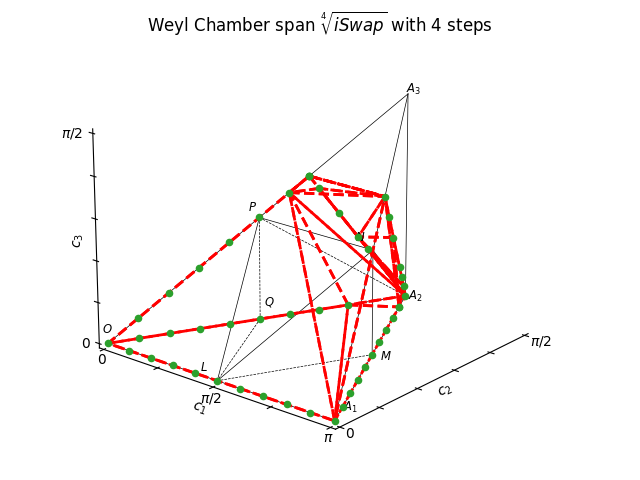

In [65]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[4])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.58333175 0.41666674 0.41666501]


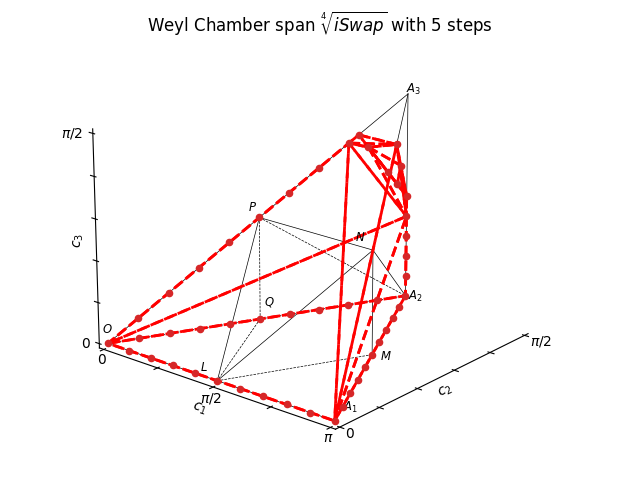

In [66]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[5])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.49992654 0.49991658 0.49991126]


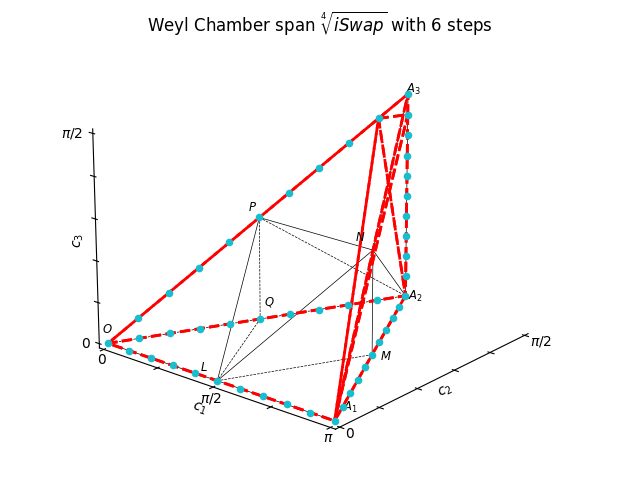

In [67]:
coordinates = weyl_region_plot(gate_params=[1/4], template_range=[6])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.2        0.10000005 0.09999995]


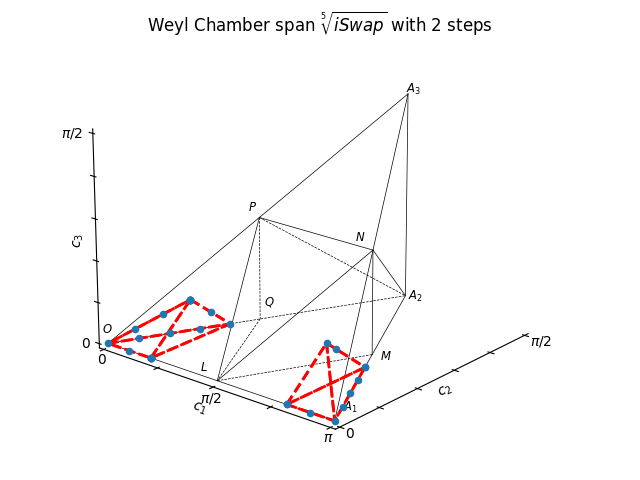

In [68]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.200001 0.2      0.199999]


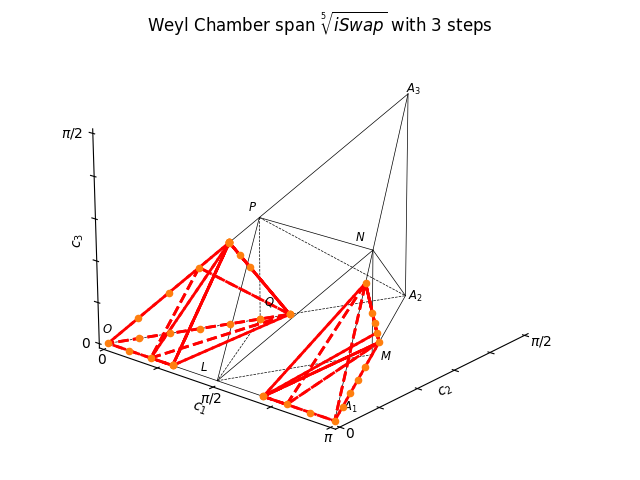

In [69]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.26666978 0.26666655 0.26666367]


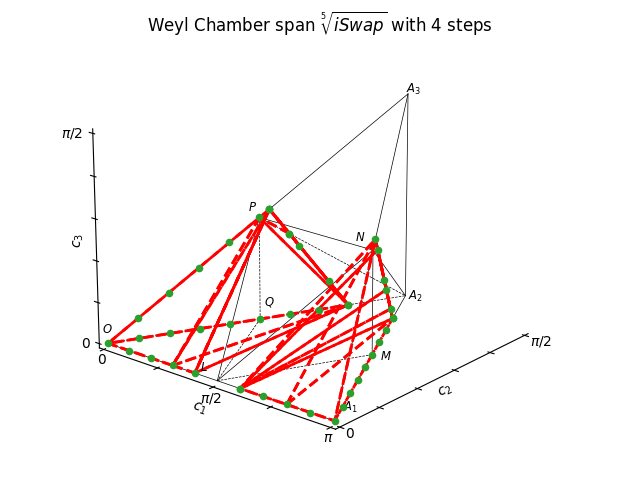

In [73]:
coordinates = weyl_region_plot(gate_params=[1/5], template_range=[4])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.16666667 0.08333335 0.08333332]


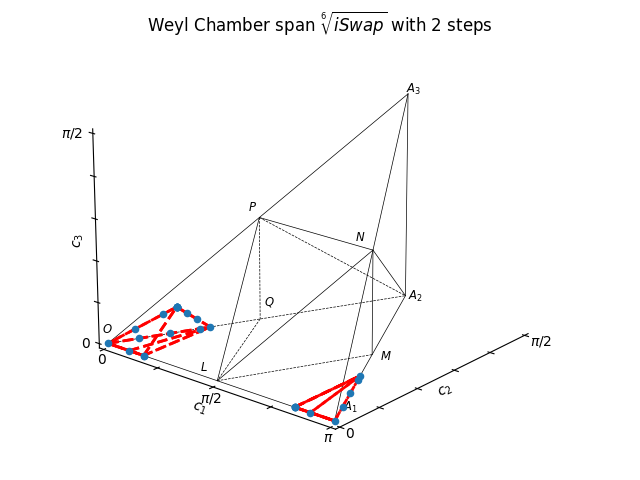

In [74]:
coordinates = weyl_region_plot(gate_params=[1/6], template_range=[2])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.16666868 0.16666731 0.16666402]


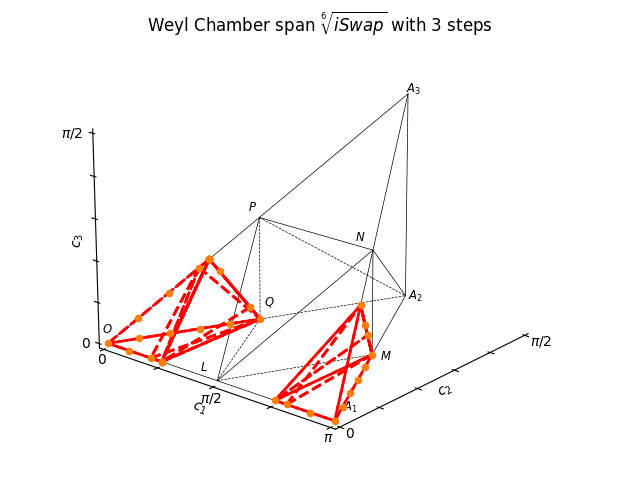

In [75]:
coordinates = weyl_region_plot(gate_params=[1/6], template_range=[3])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.22222645 0.22222177 0.22221844]


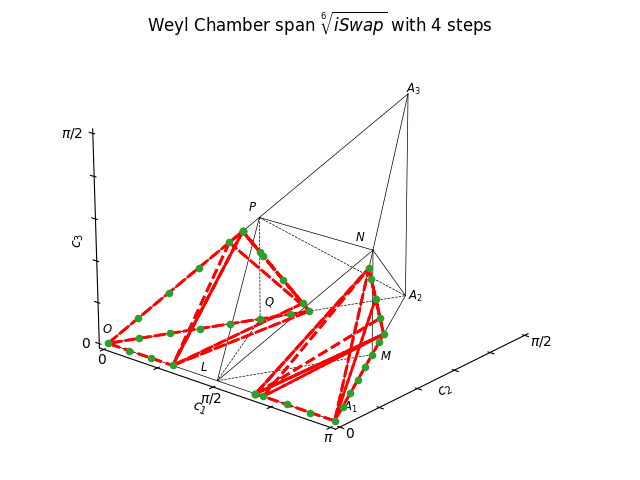

In [76]:
coordinates = weyl_region_plot(gate_params=[1/6], template_range=[4])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.27778205 0.27777782 0.27777346]


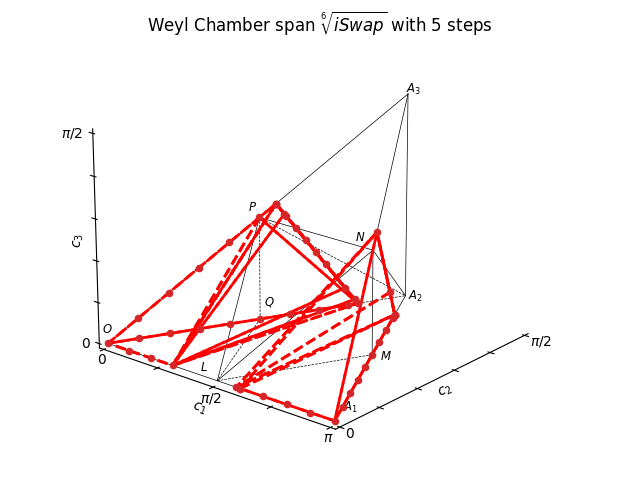

In [78]:
coordinates = weyl_region_plot(gate_params=[1/6], template_range=[5])
coordinates_left = np.array(list(filter(lambda c: c[0] < 0.5, coordinates)))
coordinates_right = np.array(list(filter(lambda c: c[0] >= 0.5, coordinates)))

for coordinate_set in (coordinates_left, coordinates_right):
    hull = ConvexHull(coordinate_set)
    for i in hull.simplices:
        i = np.append(i, i[0])
        plt.plot(coordinate_set[i,0], coordinate_set[i,1], coordinate_set[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

INFO:root:(1/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(2/66) Found saved coordinate: (0.1, 0.0, 0.0)
INFO:root:(3/66) Found saved coordinate: (0.2, 0.0, 0.0)
INFO:root:(4/66) Found saved coordinate: (0.30000000000000004, 0.0, 0.0)
INFO:root:(5/66) Found saved coordinate: (0.4, 0.0, 0.0)
INFO:root:(6/66) Found saved coordinate: (0.5, 0.0, 0.0)
INFO:root:(7/66) Found saved coordinate: (0.6000000000000001, 0.0, 0.0)
INFO:root:(8/66) Found saved coordinate: (0.7000000000000001, 0.0, 0.0)
INFO:root:(9/66) Found saved coordinate: (0.8, 0.0, 0.0)
INFO:root:(10/66) Found saved coordinate: (0.9, 0.0, 0.0)
INFO:root:(11/66) Found saved coordinate: (1.0, 0.0, 0.0)
INFO:root:(12/66) Found saved coordinate: (0.0, 0.0, 0.0)
INFO:root:(13/66) Found saved coordinate: (0.05, 0.05, 0.0)
INFO:root:(14/66) Found saved coordinate: (0.1, 0.1, 0.0)
INFO:root:(15/66) Found saved coordinate: (0.15000000000000002, 0.15000000000000002, 0.0)
INFO:root:(16/66) Found saved coordinate: (0.2, 0.2, 0.0)
I

[0.33334345 0.3333305  0.33332594]


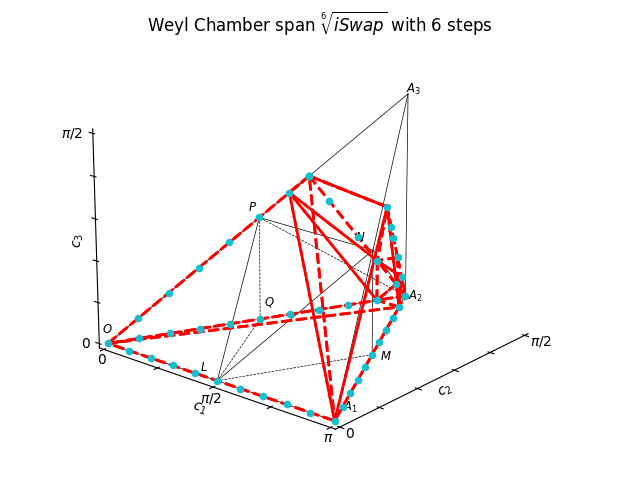

In [79]:
coordinates = weyl_region_plot(gate_params=[1/6], template_range=[6])
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
#find the max z coordinate, color it and print its location
m = max(coordinates, key=lambda x:x[2])
print(m)
plt.show()

In [ ]:
# coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[2], filename="data/weyl_spanning_syc_2.pkl")
# # hull = ConvexHull(coordinates)
# # for i in hull.simplices:
# #     i = np.append(i, i[0])
# #     plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
# plt.show()

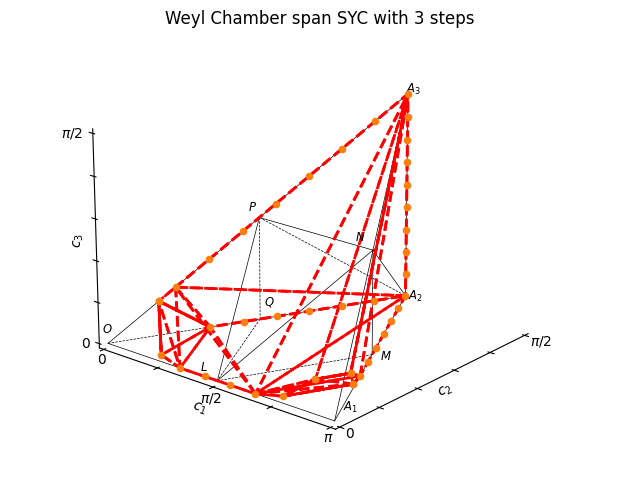

In [ ]:
# coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[3], filename="data/weyl_spanning_syc_3.pkl")
# hull = ConvexHull(coordinates)
# for i in hull.simplices:
#     i = np.append(i, i[0])
#     plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
# plt.show()

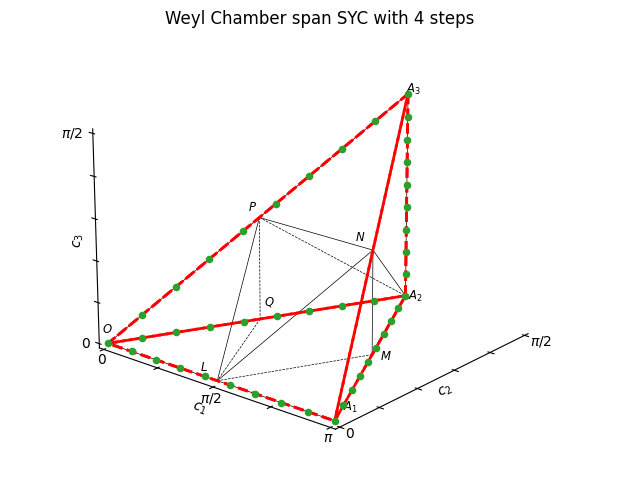

In [ ]:
coordinates = weyl_region_plot(base_gate=SYC, gate_params=[None], template_range=[4], filename="data/weyl_spanning_syc_4.pkl")
hull = ConvexHull(coordinates)
for i in hull.simplices:
    i = np.append(i, i[0])
    plt.plot(coordinates[i,0], coordinates[i,1], coordinates[i,2], 'r--', lw=2)
plt.show()

In [ ]:
#TODO coordinates => analytically defined polyehdra
# use convex hull to find vertexes
# use vertexes to define planes



In [ ]:
# #TODO plot haar gate distribution in weyl chamber
# from qiskit.quantum_info.random import random_unitary, random_clifford
# from qiskit.quantum_info import Operator
# from weylchamber import c1c2c3, WeylChamber
# w = WeylChamber()
# for _ in range(1000):
#     #coord = c1c2c3(Operator(random_unitary(dims=4)).data)
#     coord = c1c2c3(Operator(random_clifford(num_qubits=2)).data)
#     w.add_point(*coord)

# w.plot()

In [ ]:
# # from weylchamber import c1c2c3 as weyl_coordinates
# from qiskit.quantum_info.synthesis.weyl import weyl_coordinates
# def trace_to_fid(trace):
#     """Average gate fidelity is :math:`Fbar = (d + |Tr (Utarget \\cdot U^dag)|^2) / d(d+1)`
#     M. Horodecki, P. Horodecki and R. Horodecki, PRA 60, 1888 (1999)"""
#     return (4 + abs(trace) ** 2) / 2

# def num_basis_gates(unitary):
#     """Computes the number of basis gates needed in
#     a decomposition of input unitary
#     """
#     from qiskit.quantum_info.synthesis import TwoQubitBasisDecomposer
#     basis = TwoQubitBasisDecomposer(RiSwapGate).basis

#     unitary = np.asarray(unitary, dtype=complex)
#     a, b, c = weyl_coordinates(unitary)[:]
    
#     # Future gotcha: extending this to non-supercontrolled basis.
#     # Careful: closest distance between a1,b1,c1 and a2,b2,c2 may be between reflections.
#     # This doesn't come up if either c1==0 or c2==0 but otherwise be careful.
#     """:math:`|Tr(U \\cdot Utarget^dag)|`"""
#     traces = [
#         4
#         * (
#             np.cos(a) * np.cos(b) * np.cos(c)
#             + 1j * np.sin(a) * np.sin(b) * np.sin(c)
#         ),
#         4
#         * (
#             np.cos(np.pi / 4 - a) * np.cos(basis.b - b) * np.cos(c)
#             + 1j * np.sin(np.pi / 4 - a) * np.sin(basis.b - b) * np.sin(c)
#         ),
#         4 * np.cos(c),
#         4,
#     ]
#     basis_fidelity=1.0
#     return np.argmax([trace_to_fid(traces[i]) * basis_fidelity**i for i in range(4)])

# from qiskit.circuit.library.standard_gates import *
# num_basis_gates(SwapGate())